# `wisesight-sentiment` Kaggle Competition

This notebook details the steps taken to compete in the [WISESIGHT Sentiment Analysis](https://www.kaggle.com/c/wisesight-sentiment/) competition. Competition metric is overall accuracy across `neg`ative, `pos`itive, `neu`tral and `q`uestion classes.

Our optimal strategy was:
1. Train a logistic regression model (L2 regularization; C=2.0) with tf-idf features (minimum frequency = 20) and predict on the test set. Also output probabilities for each class of the test set.

2. Combine the training set with test set labeled by the previous logistic regression model to create the augmented set.

3. Finetune a ULMFit language mdoel (minimum frequency = 2) with all data available with the following hyperparameters:

```
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=1., clip=0.12, alpha=2, beta=1)
```

4. Train a ULMFit classification model with the augmented set (minimum frequency = 20). Output probabilities for each class of the test set. The hyperparameters are as follows:

```
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
trn_args = dict(bptt=70, drop_mult=0.7, alpha=2, beta=1, max_len=500)
```

5. Take an average the probabilities outputed by model in 1. and 3. Predict the class with the highest average probabilities.

At every step, we first trained with a 85/15 validation set for a decent set hyperparameters then train with 95/5 split afterwards before proceeding to the next step.

The results for Logistic Regression, FastText, ULMFit, ULMFit with semi-supervised data are as follows:

| Model               | Public Accuracy | Private Accuracy |
|---------------------|-----------------|------------------|
| Logistic Regression | 0.72781         | 0.7499           |
| FastText            | 0.63144         | 0.6131           |
| ULMFit              | 0.71259         | 0.74194          |
| ULMFit Semi-supervised    | 0.73119     | 0.75859      |
| ULMFit Semi-supervised Repeated One Time    | **0.73372**     | **0.75968**      |
| [USE](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3)    | 0.63987*   |
* Done after competition with a test set that was cleaned from 3946 rows to 2674 rows


Things that we tried and did not help:

* Rules based on error analysis
* Sub-model to predict positive class out of those that we predicted as neutral (since `true label = pos / predicted label = neutral` is by far the largest error group)
* SVD to decompose tf-idf features
* Adding average/sum embeddings of finetuned language model to features
* Sparse features and multi-layer perceptrons
* Removing duplicated rows
* Over/undersampling
* Randomly initialized bi-directional AWD-LSTM with "cleaner" processing rules
* Generate fake samples and retrain with ULMFit

In [0]:
#uncomment if running from colab
# !wget https://github.com/PyThaiNLP/wisesight-sentiment/archive/master.zip; unzip master.zip
# !mv wisesight-sentiment-master/kaggle-competition/* .
# !pip install tensorflow_text
# !pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install emoji
# !ls

In [0]:
import pandas as pd
import numpy as np
from pythainlp import word_tokenize
from tqdm import tqdm_notebook
import re
import emoji

#viz
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

## Text Processor for Logistic Regression

In [0]:
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    
    #tokenize
    res = [word for word in word_tokenize(res) if word and not re.search(pattern=r"\s+", string=word)]
    
    #post rules
    res = ungroup_emoji(res)
    
    return res

## Process Text Files to CSVs

In [16]:
# with open('train.txt') as f:
#     texts = [line.strip() for line in f.readlines()]
# f.close()

# with open('train_label.txt') as f:
#     categories = [line.strip() for line in f.readlines()]
# f.close()

# all_df = pd.DataFrame({'category':categories, 'texts':texts})
# all_df.to_csv('all_df.csv',index=False)
# all_df.shape

(24063, 2)

In [17]:
# with open('test.txt') as f:
#     texts = [line.strip() for line in f.readlines()]
# f.close()

# test_df = pd.DataFrame({'category':'test', 'texts':texts})
# test_df.to_csv('test_df.csv',index=False)
# test_df.shape

(2674, 2)

## Load Data

In [0]:
all_df = pd.read_csv('all_df.csv')
test_df = pd.read_csv('test_df.csv')

all_df['processed'] = all_df.texts.map(lambda x: '|'.join(process_text(x)))
all_df['wc'] = all_df.processed.map(lambda x: len(x.split('|')))
all_df['uwc'] = all_df.processed.map(lambda x: len(set(x.split('|'))))

test_df['processed'] = test_df.texts.map(lambda x: '|'.join(process_text(x)))
test_df['wc'] = test_df.processed.map(lambda x: len(x.split('|')))
test_df['uwc'] = test_df.processed.map(lambda x: len(set(x.split('|'))))

In [23]:
#prevalence
all_df.category.value_counts() / all_df.shape[0]

neu    0.544612
neg    0.255164
pos    0.178698
q      0.021527
Name: category, dtype: float64

## Train-validation Split

We perform 85/15 random train-validation split. We also perform under/oversampling to balance out the classes a little.

In [0]:
#when finding hyperparameters
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

#when actually doing it
# train_df = all_df.copy()
# valid_df = pd.read_csv('valid_df.csv')

In [25]:
valid_df.head()

,category,texts,processed,wc,uwc
0,neu,เห็นคนลบแอพ viu ก็เห็นใจและเข้าใจเขานะคะ แผลมั...,เห็น|คน|ลบ|แอพ|viu|ก็|เห็นใจ|และ|เข้าใจ|เขา|นะ...,46,41
1,neu,ไปชมไม้คิวของแชมป์ และรองแชมป์ กันจ้า! ..........,ไป|ชม|ไม้คิว|ของ|แชมป์|และ|รอง|แชมป์|กัน|จ้า|!...,41,39
2,neg,กลุ่มรถซีวิคเป็นกลุ่มที่น่ารำคานมากกกกกกกกก อว...,กลุ่ม|รถ|ซีวิค|เป็น|กลุ่ม|ที่|น่า|รำ|คาน|มาก|x...,46,35
3,neu,อยากสวยเหมือนเจ้าของแบรนด์สิคะ เนย โชติกา ใบหน...,อยาก|สวย|เหมือน|เจ้าของ|แบรนด์|สิ|คะ|เนย|โชติ|...,72,56
4,neg,ข้าวโถละร้อย แพง เพราะตักเป็นจานๆละ15 เต็มที่ก...,ข้าว|โถ|ละ|ร้อย|แพง|เพราะ|ตัก|เป็น|จาน|ๆ|ละ|15...,385,215


In [26]:
#prevalence
print(train_df['category'].value_counts() / train_df.shape[0])

neu    0.544957
neg    0.253557
pos    0.180071
q      0.021415
Name: category, dtype: float64


In [28]:
#prevalence
print(valid_df['category'].value_counts() / valid_df.shape[0])

neu    0.542659
neg    0.264266
pos    0.170914
q      0.022161
Name: category, dtype: float64


## Logistic Regression

### Create Features

In [0]:
#dependent variables
y_train = train_df['category']
y_valid = valid_df['category']

In [0]:
#text faetures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(all_df['texts'])
text_train = tfidf_fit.transform(train_df['texts'])
text_valid = tfidf_fit.transform(valid_df['texts'])
text_test = tfidf_fit.transform(test_df['texts'])
text_train.shape, text_valid.shape

((20693, 4841), (3652, 4841))

In [0]:
#word count and unique word counts; actually might not be so useful
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_fit = scaler.fit(all_df[['wc','uwc']].astype(float))
print(scaler_fit.mean_, scaler_fit.var_)
num_train = scaler_fit.transform(train_df[['wc','uwc']].astype(float))
num_valid = scaler_fit.transform(valid_df[['wc','uwc']].astype(float))
num_test = scaler_fit.transform(test_df[['wc','uwc']].astype(float))
num_train.shape, num_valid.shape

[22.2505648  18.41499281] [1108.92025281  497.704347  ]


((20693, 2), (3652, 2))

In [0]:
#concatenate text and word count features
X_train = np.concatenate([num_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid,text_valid.toarray()],axis=1)
X_test = np.concatenate([num_test,text_test.toarray()],axis=1)
X_train.shape, X_valid.shape

((20693, 4843), (3652, 4843))

### Fit Model

In [0]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty='l2', solver='liblinear', dual=False, multi_class='ovr')
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

0.7305585980284776

### See Results

In [0]:
probs = model.predict_proba(X_valid)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df['preds'] = model.predict(X_valid)
probs_df['category'] = valid_df.category
probs_df['texts'] = valid_df.texts
probs_df['processed'] = valid_df.processed
probs_df['wc'] = valid_df.wc
probs_df['uwc'] = valid_df.uwc
probs_df['hit'] = (probs_df.preds==probs_df.category)
probs_df.to_csv('probs_df_linear.csv',index=False)

0.7305585980284776


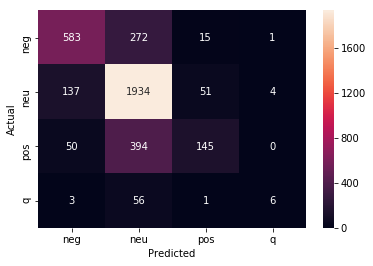

In [0]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(probs_df.category,probs_df.preds)
print(model.score(X_valid,y_valid))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Export Augmented Dataset

In [0]:
test_df['category'] = model.predict(X_test)
all_aug = pd.concat([test_df,all_df]).reset_index(drop=True)
print(all_aug.shape)
# all_aug.to_csv('all_aug.csv',index=False)

(28291, 5)


### Submission

In [0]:
# preds = model.predict(text_test)
# submit = pd.read_csv('test_majority.csv')
# submit['Class'] = preds
# print(submit.shape)
# submit.to_csv('submit_linear.csv',index=False)
# submit.tail()

## [ULMFit](https://github.com/cstorm125/thai2fit) Model

In [0]:
from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback
from pythainlp.ulmfit import *

model_path = 'wisesight_data/'

In [0]:
#when training to find hyperparameters
all_df = pd.read_csv('all_df.csv')
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)

#when training with augmented set
# train_df = pd.read_csv('all_aug.csv')

#test set
# test_df = pd.read_csv('test_df.csv')

### Finetune Language Model

In [0]:
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=2)]

data_lm = (TextList.from_df(all_df, model_path, cols='texts', processor=processor)
    .random_split_by_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=48))
data_lm.sanity_check()
# data_lm.save('wisesight_lm.pkl')

In [0]:
data_lm.sanity_check()
len(data_lm.train_ds), len(data_lm.valid_ds)

(24102, 243)

In [0]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=1., clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

In [0]:
#train frozen
print('training frozen')
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

training frozen


epoch,train_loss,valid_loss,accuracy
1,4.584492,4.061413,0.377183


In [0]:
#train unfrozen
print('training unfrozen')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8, 0.7))

training unfrozen


epoch,train_loss,valid_loss,accuracy
1,4.132607,3.788304,0.405754
2,3.942456,3.627463,0.424405
3,3.716612,3.527803,0.436210
4,3.534183,3.482676,0.439385
5,3.438706,3.465490,0.440675


In [0]:
# learn.save('wisesight_lm')
# learn.save_encoder('wisesight_enc')

### Train Text Classifier

In [0]:
#lm data
data_lm = load_data(model_path,'wisesight_lm.pkl')
data_lm.sanity_check()

#classification data
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=20)]

data_cls = (ItemLists(model_path,train=TextList.from_df(train_df, model_path, cols=['texts'], processor=processor),
                     valid=TextList.from_df(valid_df, model_path, cols=['texts'], processor=processor))
    .label_from_df('category')
    .add_test(TextList.from_df(test_df, model_path, cols=['texts'], processor=processor))
    .databunch(bs=50)
    )
data_cls.sanity_check()
print(len(data_cls.vocab.itos))

28234


In [0]:
#model
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
trn_args = dict(bptt=70, drop_mult=0.7, alpha=2, beta=1, max_len=500)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
#load pretrained finetuned model
learn.load_encoder('wisesight_enc')

In [0]:
# #train unfrozen
# learn.freeze_to(-1)
# learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))
# learn.freeze_to(-2)
# learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))
# learn.freeze_to(-3)
# learn.fit_one_cycle(1, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7))
# learn.unfreeze()
# learn.fit_one_cycle(10, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7),
#                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestmodel')])

Training takes about 20 minutes so we use the script `train_model.py` to do it with the following results (validation run):

```
epoch     train_loss  valid_loss  accuracy
1         0.812156    0.753478    0.687532
Total time: 00:56
epoch     train_loss  valid_loss  accuracy
1         0.740403    0.699093    0.714394
Total time: 00:57
epoch     train_loss  valid_loss  accuracy
1         0.727394    0.668807    0.723011
Total time: 01:34
epoch     train_loss  valid_loss  accuracy
1         0.722163    0.675351    0.723517
2         0.675266    0.654477    0.738723
3         0.669178    0.641070    0.737962
4         0.612528    0.637456    0.744551
5         0.618259    0.635149    0.749366
6         0.572621    0.651169    0.749873
7         0.561985    0.661739    0.747593
8         0.534753    0.673563    0.738469
9         0.530844    0.688871    0.746072
10        0.522788    0.670024    0.743031
Total time: 23:42
```

### See Results

In [0]:
learn.load('bestmodel');
#get predictions
probs, y_true, loss = learn.get_preds(ds_type = DatasetType.Valid, ordered=True, with_loss=True)
classes = learn.data.train_ds.classes
y_true = np.array([classes[i] for i in y_true.numpy()])
preds = np.array([classes[i] for i in probs.argmax(1).numpy()])
prob = probs.numpy()
loss = loss.numpy()

In [0]:
to_df = np.concatenate([y_true[:,None],preds[:,None],loss[:,None],prob],1)
probs_df = pd.DataFrame(to_df)
probs_df.columns = ['category','preds','loss'] + classes
probs_df['hit'] = (probs_df.category == probs_df.preds)
probs_df['texts'] = valid_df.texts
(y_true==preds).mean()

0.8392661555312158

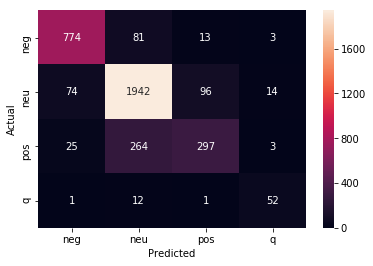

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(probs_df.category,probs_df.preds)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Submission

In [0]:
# submit = pd.read_csv('test_majority.csv')
# submit['Class'] = preds
# print(submit.shape)
# submit.to_csv('submit_ulmfit.csv',index=False)
# submit.tail()

## Average Class Probabilities

In [0]:
#ulmfit trained with augmented set
probs_df_ulmfit = pd.read_csv('probs_df_ulmfit.csv')

#logistic regression trained with training set
probs_df = pd.read_csv('probs_df_linear.csv')

probs_df_ulmfit.head()

,category,preds,loss,neg,neu,pos,q,hit,texts,processed,wc
0,neu,neu,0.490570,0.093375,0.612277,0.292863,0.001485,True,กระเทียม?,กระเทียม|?,2
1,neu,neu,0.234147,0.006215,0.791245,0.199381,0.003158,True,ได้สิค่ะ รออะไร555,ได้|สิ|ค่ะ|รอ|อะไร|5|xxrep,7
2,neu,neu,0.009935,0.001864,0.990114,0.007970,0.000052,True,❤️💕❤️หนุ่ม กะลา คอนเสิร์ตที่เนคตาผับ หาดใหญ่ 2...,❤️💕❤️|หนุ่ม|กะลา|คอนเสิร์ต|ที่|เนค|ตา|ผับ|หาดใ...,51
3,neu,neu,0.112569,0.005808,0.893536,0.100359,0.000297,True,555555,5|xxrep,2
4,neu,neu,0.007246,0.000022,0.992780,0.005423,0.001775,True,สามารถสั่งกลับบ้านได้ตามช่วงเวลาที่ให้บริการค่...,สามารถ|สั่ง|กลับบ้าน|ได้|ตาม|ช่วงเวลา|ที่|ให้บ...,10


In [0]:
#ulmfit probabilities
ulm = np.array(ulmfit_probs[['neg','neu','pos','q']])[None,:]

#logistic regression probabilities
lr = np.array(probs_df[['neg','neu','pos','q']])[None,:]

#take average
mean_probs = np.concatenate([lr,ulm],0).mean(0)
mean_preds = np.argmax(mean_probs,1)
mean_preds = np.array([['neg','neu','pos','q'][i] for i in mean_preds])

### Submit

In [0]:
# preds = model.predict(text_test)
# submit = pd.read_csv('test_majority.csv')
# submit['Class'] = mean_preds
# print(submit.shape)
# submit.to_csv('submit_mean.csv',index=False)
# submit.tail()

## FastText

In [0]:
import codecs

def replace_newline(t):
    return re.sub('[\n]{1,}', ' ', t)

ft_data = 'ft_data/'

train_df = pd.read_csv('all_df.csv')
test_df = pd.read_csv('test_df.csv')
all_df = pd.concat([train_df,test_df],0).reset_index(drop=True)

In [0]:
df_txts = ['train','test']
dfs = [train_df,test_df]

for i in range(2):
    df = dfs[i]
    ft_lines = []
    for _,row in df.iterrows():
        ft_lab = f'__label__{row["category"]}'
        ft_text = replace_newline(f'{row["texts"]}')
        ft_line = f'{ft_lab} {ft_text}'
        ft_lines.append(ft_line)

    doc = '\n'.join(ft_lines)
    with codecs.open(f'{ft_data}{df_txts[i]}.txt','w', encoding="utf-8") as f:
        f.write(doc)
    f.close()

In [0]:
#for fasttext embedding finetuning
ft_lines = []
for _,row in all_df.iterrows():
    ft_lab = '__label__0'
    ft_text = replace_newline(f'{row["texts"]}')
    ft_line = f'{ft_lab} {ft_text}'
    ft_lines.append(ft_line)

doc = '\n'.join(ft_lines)
with codecs.open(f'{ft_data}all.txt','w', encoding="utf-8") as f:
    f.write(doc)
f.close()

In [0]:
#finetune with all data
!/root/fastText/fasttext skipgram \
-pretrainedVectors 'model/wiki.th.vec' -dim 300 \
-input ft_data/all.txt -output 'model/finetuned'

Read 0M words
Number of words:  3625
Number of labels: 1
Progress: 100.0% words/sec/thread:   16793 lr:  0.000000 loss:  1.099992 ETA:   0h 0m


In [0]:
#train classifier
!/root/fastText/fasttext supervised \
-input 'ft_data/train.txt' -output 'model/sentiment' \
-pretrainedVectors 'model/finetuned.vec' -epoch 5 -dim 300 -wordNgrams 2

Read 0M words
Number of words:  92612
Number of labels: 4
Progress: 100.0% words/sec/thread:  262850 lr:  0.000000 loss:  0.420523 ETA:   0h 0m


In [0]:
#get prediction
preds = !/root/fastText/fasttext predict 'model/sentiment.bin' 'ft_data/test.txt'
preds = [i.split('__')[-1] for i in preds]

In [0]:
submit = pd.read_csv('test_majority.csv')
submit['Class'] = preds
print(submit.shape)
submit.to_csv('submit_fasttext.csv',index=False)
submit.tail()

(3946, 2)


,Id,Class
3941,3942,neu
3942,3943,neu
3943,3944,neu
3944,3945,neg
3945,3946,neu


## [Multilingual Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3)

In [0]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf #tensorflow 2.1.0

enc = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')

In [0]:
#dependent variables
y_train = train_df['category']
y_test = test_df['category']

In [0]:
X_trains = []
X_tests = []
bs = 10

In [39]:
for i in tqdm_notebook(range(y_test.shape[0]//bs+1)):
    X_tests.append(enc(test_df.texts[(i*bs):((i+1)*bs)]).numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [42]:
for i in tqdm_notebook(range(y_train.shape[0]//bs+1)):
    X_trains.append(enc(train_df.texts[(i*bs):((i+1)*bs)]).numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [43]:
X_test = np.concatenate(X_tests,0)
X_train = np.concatenate(X_trains,0)
X_train.shape, X_test.shape

((20453, 512), (2674, 512))

In [45]:
from sklearn.svm import LinearSVC

text_clf = LinearSVC(class_weight='balanced')
text_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [48]:
# preds = text_clf.predict(X_test)
# submit = pd.read_csv('test_majority.csv')
# submit['Class'] = preds
# print(submit.shape)
# submit.to_csv('submit_use.csv',index=False)
# submit.tail()

(2674, 2)


,Id,Class
2669,2670,pos
2670,2671,neg
2671,2672,neu
2672,2673,neu
2673,2674,neu


In [52]:
(lab.Class==submit.Class).mean()

0.6398653702318624